# Read SNOWPACK Output
This script will read in output from SNOWPACK, and also plot it with SUMup data. 

## Begin user input

In [156]:
sumup_lats = [-76.952,-76.77,-75.5815,-75.002335]
sumup_lons = [-121.22,-101.738,-3.430333,0.007]
corenames = ['THW2010','DIV2010','DML07C98_31','DML05C98_32']

## End user input

In [147]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.path as mpath

# Set up plotting aesthetics
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 12
mpl.rcParams['mathtext.fontset'] = 'cm'
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [148]:
# Open dataset
sumup = xr.open_dataset('sumup_density_2020.nc')

# Extract data
su_citation = sumup['Citation'].values
su_date = sumup['Date'].values
su_lat = sumup['Latitude'].values
su_lon = sumup['Longitude'].values
su_depth0 = sumup['Start_Depth'].values
su_depth1 = sumup['Stop_Depth'].values
su_midpoint = sumup['Midpoint'].values
su_density = sumup['Density'].values

In [149]:
# SUMup dataframe
data_sumup = {'Citation':su_citation,'Date':su_date,'Latitude':su_lat,'Longitude':su_lon,
              'Depth':su_midpoint,'Density':su_density*1000}
df = pd.DataFrame(data=data_sumup)

# Give each firn core its unique index
n = -1
id0 = []
for i in range(len(su_citation)-1):
    if (su_citation[i]==su_citation[i-1] and su_lat[i]==su_lat[i-1]):
        index = n
    else:
        n += 1
        index = n
    id0.append(index)
id0.append(id0[-1])

# Give each datapoint within a core index its own index
m = -1
id1 = []
for i in range(len(id0)-1):
    if id0[i] == id0[i-1]:
        m += 1
    else:
        m = 0
    id1.append(m)
id1.append(id1[-1]+1)
    
df['CoreID'] = id0
idx0 = pd.Series(data=id0,name='Core')
idx1 = pd.Series(data=id1,name='Index')
idx_arrays = [idx0,idx1]
df.index = idx_arrays

In [150]:
# Define function to print core ID when given lat, lon, citation, and/or date
def sumupID(lat=0,lon=0,cit=0,date=0):
    if lat == 0:
        core = df.CoreID[(df.Citation == cit) & (df.Date == date)][0]
    elif lat > 0:
        core = df.CoreID[(df.Latitude == lat) & (df.Longitude == lon)][0]
    return core

# Define function to print core ID when given lat, lon, citation, and/or date
def sumupID(lat=0,lon=0,cit=0,date=0):
    if lat == 0:
        core = df.CoreID[(df.Citation == cit) & (df.Date == date)][0]
    if cit == 0:
        core = df.CoreID[(df.Latitude == lat) & (df.Longitude == lon)][0]
    return core

In [151]:
# MERRA-2 points
points = pd.read_table('../input-data-scripts/MERRA-2_Lat_Lon_SUMup_GNSS.txt',
                       header=None,skiprows=1,sep=' ',names=['lat','lon'])

# Haversine formula for calculating distance between two points on Earth
def haversine(lat1,lon1,lat2,lon2):
    phi1 = np.deg2rad(lat1)
    phi2 = np.deg2rad(lat2)
    theta1 = np.deg2rad(lon1)
    theta2 = np.deg2rad(lon2)
    del_phi = phi2-phi1
    del_theta = theta2-theta1
    a = np.sin(del_phi/2)**2 + (np.cos(phi1)*np.cos(phi2)*np.sin(del_theta/2)**2)
    c = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    d = (6371e3)*c # Earth's radius in meters
    return d # Meters

def sumup2merra(lat1,lon1):
    dist = []
    for i in range(len(points)):
        lat2 = points.lat[i]
        lon2 = points.lon[i]
        d = haversine(lat1,lon1,lat2,lon2)
        dist.append(d)
    p = np.where(dist == min(dist))
    return points.loc[p]

In [152]:
# Function for reading in .pro file
def read_pro(pro):
    
    f = open(pro,'r')
    
    # Header is 47 lines
    for i in range(47):
        header = f.readline()
    
    # After header, read in rest of data
    data = f.readlines()
    
    # Create empty list for data
    data_all = list()
    
    # Read lines in data
    for line in data:
        # Date
        if line[0:4] == '0500':
            d = line.split(',')[1].split('.')
            timestamp = datetime.datetime(int(d[2][0:4]), int(d[1]), int(d[0]), int(d[2][5:7]))
            data_dict = {} # Create dictionary of data for each timestamp
            data_dict['Date'] = timestamp
        # Depth (m)
        elif line[0:4] == '0501':
            depth_dict = list(map(float, line.split('\n')[0].split(',')[2:]))
            depth_dict = np.asarray(depth_dict)/100 # Convert from cm to m
        # Density (kg/m^3)
        elif line[0:4] == '0502':
            density_dict = list(map(float, line.split('\n')[0].split(',')[2:]))
            density_dict = np.asarray(density_dict)
        # Snow temperature (K)
        elif line[0:4] == '0503': 
            temp_dict = list(map(float, line.split('\n')[0].split(',')[2:]))
            temp_dict = np.asarray(temp_dict)
        # Water content (%)
        elif line[0:4] == '0506':
            water_dict = list(map(float, line.split('\n')[0].split(',')[2:]))
            water_dict = np.asarray(water_dict)  
        # Ice content (%)
        elif line[0:4] == '0515':
            ice_dict = list(map(float, line.split('\n')[0].split(',')[2:]))
            ice_dict = np.asarray(ice_dict)
        # Air content (%)
        elif line[0:4] == '0516':
            air_dict = list(map(float, line.split('\n')[0].split(',')[2:]))
            air_dict = np.asarray(air_dict)
        
        # Create firn profiles
            data_dict['Depth'] = depth_dict[i:]
            data_dict['Density'] = density_dict[i:]
            data_dict['Tempearture'] = temp_dict[i:]
            data_dict['Air'] = air_dict[i:]/100
            data_dict['Water'] = water_dict[i:]/100
            data_dict['Ice'] = ice_dict[i:]/100
            data_dict['Density_total'] = density_dict
            data_dict['Depth_total'] = depth_dict
            data_dict['Depth_inv'] = depth_dict[-1]-depth_dict+depth_dict[0]
            
            data_all.append(data_dict)
        
    return data_all
    
    f.close()

In [153]:
# SUMup core, SUMuplat, SUMuplon, MERRA ID (VIR__), MERRAlat, MERRAlon
metadata = np.zeros((len(sumup_lats),6))
for i in range(len(sumup_lats)):
    metadata[i,0] = sumupID(lat=sumup_lats[i],lon=sumup_lons[i]) # Core ID
    metadata[i,1] = sumup_lats[i] # Core latitude (input)
    metadata[i,2] = sumup_lons[i] # Core latitude (output)
    merra = sumup2merra(sumup_lats[i],sumup_lons[i])
    metadata[i,3] = merra.index[0] + 1 # MERRA ID; VIR indexing starts at 0
    metadata[i,4] = merra.lat.values[0]
    metadata[i,5] = merra.lon.values[0]

df_meta = pd.DataFrame(metadata,columns=['SUMupID','SUMupLat','SUMupLon','VIR','MERRALat','MERRALon'])
df_meta

,SUMupID,SUMupLat,SUMupLon,VIR,MERRALat,MERRALon
0,86.0,-76.952000,-121.220000,154.0,-77.0,-1.212500e+02
1,87.0,-76.770000,-101.738000,155.0,-77.0,-1.018750e+02
2,432.0,-75.581500,-3.430333,184.0,-75.5,-3.125000e+00
3,450.0,-75.002335,0.007000,203.0,-75.0,-5.920304e-13


## Plot locations from MERRA-2 and SUMup

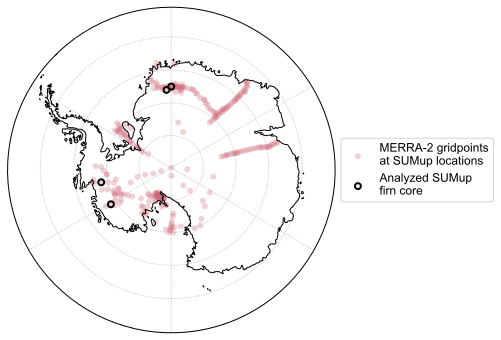

In [154]:
# Set up figure for plotting
projection=ccrs.SouthPolarStereo()
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(1, 1, 1, projection=projection)
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax.coastlines(resolution='50m',color='k')
gl = ax.gridlines(linestyle=':',zorder=0)
gl.n_steps = 90
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Plot unique MERRA-2 gridpoints for SUMup locations
ax.scatter(points.lon,points.lat,transform=ccrs.PlateCarree(),
           color='#CC6677',alpha=0.3,edgecolors='none',label='MERRA-2 gridpoints\nat SUMup locations')
# Plot analyzed SUMup core locations
ax.scatter(df_meta.SUMupLon,df_meta.SUMupLat,transform=ccrs.PlateCarree(),
           color='none',edgecolors='k',linewidths=2,label='Analyzed SUMup\nfirn core')

ax.legend(loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

## Plot firn data

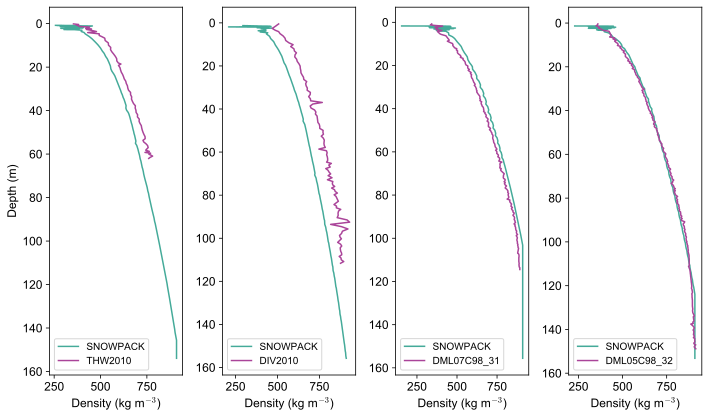

In [159]:
fig, ax = plt.subplots(1, len(df_meta), figsize=(10,6))

for i in range(len(df_meta)):
    
    # Read in SNOWPACK data
    VIR = str(int(df_meta.VIR[i]))
    file = read_pro('VIR'+VIR+'_AIS.pro')
    
    # Prepare axes
    ax[0].set_ylabel('Depth (m)')
    ax[i].set_xlabel(r'Density (kg m$^{-3}$)')
    
    # Plot SNOWPACK results
    ax[i].plot(file[-1]['Density_total'],file[-1]['Depth_inv'],c='#44AA99',label='SNOWPACK')
    # Plot SUMup data
    ax[i].plot(df.loc[df_meta.SUMupID[i]].Density,df.loc[df_meta.SUMupID[i]].Depth,c='#AA4499',label=corenames[i])
    
    ax[i].invert_yaxis()
    ax[i].legend(prop={"size":10})

plt.tight_layout()